In [10]:
# Band pass filter
import numpy as np
from scipy.signal import butter, lfilter
from pydub import AudioSegment
from pydub.utils import get_array_type
import os

# Function to design a Butterworth band-pass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Function to apply the filter
def apply_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Main function to read an audio file, apply the filter, and save the output
def bandpass_filter(input_file, output_file, lowcut=70.0, highcut=20000.0):
    # Load audio file
    audio = AudioSegment.from_file(input_file)
    
    # Get raw audio data as a bytestring
    raw_data = np.array(audio.get_array_of_samples())

    # Get the sample rate of the audio file
    fs = audio.frame_rate

    # Determine the array type of the audio (e.g., int16, int32, etc.)
    array_type = get_array_type(audio.sample_width * 8)
    dtype = np.dtype(array_type)

    # Apply band-pass filter
    filtered_data = apply_filter(raw_data, lowcut, highcut, fs)

    # Create a new audio segment from filtered data
    filtered_audio = AudioSegment(
        filtered_data.astype(dtype).tobytes(), 
        frame_rate=fs, 
        sample_width=audio.sample_width, 
        channels=audio.channels
    )

    # Export the filtered audio to a file
    filtered_audio.export(output_file, format="mp3")
    print(f"Filtered audio saved as {output_file}")

# Example usage
input_file = '../KeyRing1/label/labeled/KeyD.mp3'  # Replace with your audio file path
output_file = '../KeyRing1/label/labeled/KeyD_filtered.mp3'  # Replace with your output file path
bandpass_filter(input_file, output_file)


Filtered audio saved as ../KeyRing1/label/labeled/KeyD_filtered.mp3


In [11]:
# Frame Energies are used to find direction of single axis movement but spectral energy required for multiple axis movement
import librosa
import numpy as np

def frame_energy(audio_file, frame_length_ms):
    # Load the audio file (y is the audio time series, sr is the sample rate)
    y, sr = librosa.load(audio_file, sr=None)
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Split the audio into frames and compute energy for each frame
    num_frames = len(y) // frame_length
    energies = []
    
    for i in range(num_frames):
        frame = y[i * frame_length:(i + 1) * frame_length]
        # Calculate energy (sum of squares of the frame)
        energy = np.sum(frame ** 2)
        energies.append(energy)
    
    return np.array(energies)


In [12]:
# High when printer isnt making any sound and low when it is printing
import librosa
import numpy as np

def compute_zcr(audio_file, frame_length_ms):
    # Load the audio file (y is the audio time series, sr is the sample rate)
    y, sr = librosa.load(audio_file, sr=None)
    
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Split the audio into frames and compute ZCR for each frame
    num_frames = len(y) // frame_length
    zcrs = []
    
    for i in range(num_frames):
        frame = y[i * frame_length:(i + 1) * frame_length]
        
        # Calculate zero crossing rate manually using the formula
        sign_changes = np.abs(np.sign(frame[1:]) - np.sign(frame[:-1]))
        zcr = np.sum(sign_changes ** 2) / (2 * frame_length)
        zcrs.append(zcr)
    
    return np.array(zcrs)

In [13]:
#Energy entropy measures the abrupt change in the energy of the signal, and can be used to detect the change of motion.
import librosa
import numpy as np

def compute_energy_entropy(audio_file, frame_length_ms, K):
    # Load the audio file (y is the audio time series, sr is the sample rate)
    y, sr = librosa.load(audio_file, sr=None)
    
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Split the audio into frames and compute energy entropy for each frame
    num_frames = len(y) // frame_length
    energy_entropy_list = []
    
    for i in range(num_frames):
        frame = y[i * frame_length:(i + 1) * frame_length]
        
        # Divide the frame into K sub-frames
        sub_frame_length = frame_length // (K)
        sub_frame_energies = []
        
        for j in range(K):
            sub_frame = frame[j * sub_frame_length:(j + 1) * sub_frame_length]
            # Calculate energy of the sub-frame
            sub_frame_energy = np.sum(sub_frame ** 2)
            sub_frame_energies.append(sub_frame_energy)
        
        # Normalize the sub-frame energies to get e_j
        total_energy = np.sum(sub_frame_energies)
        e_j = np.array(sub_frame_energies) / total_energy if total_energy > 0 else np.zeros(K)
        
        # Calculate energy entropy using the formula
        energy_entropy = -np.sum(e_j * np.log2(e_j + 1e-12))  # Small value added to avoid log(0)
        energy_entropy_list.append(energy_entropy)
    
    return np.array(energy_entropy_list)

In [14]:
#For frequency domain data, let 𝑋𝑖(𝑘), 𝑘 = 1, ..., 𝐹𝐿 be the magnitude of the Fast Fourier Transform (FFT) coefficient of the given frame.
import numpy as np
import librosa

def compute_fft_magnitudes(filename, frame_length_ms):
    # Load the audio file
    audio, sample_rate = librosa.load(filename, sr=None)

    # Convert frame length from milliseconds to samples
    frame_length = int(sample_rate * frame_length_ms / 1000)

    # Number of frames (using a hop length equal to the frame length)
    num_frames = len(audio) // frame_length

    # Initialize a list to store FFT magnitudes for each frame
    fft_magnitudes = []

    # Iterate through each frame
    for i in range(num_frames):
        # Extract the frame
        frame = audio[i * frame_length : (i + 1) * frame_length]

        # Apply FFT to the frame
        fft_result = np.fft.fft(frame)

        # Compute the magnitude of the FFT coefficients
        magnitude = np.linalg.norm(np.abs(fft_result))
        
        # Append the magnitude to the list
        fft_magnitudes.append(magnitude)

    # Convert the list to a NumPy array
    fft_magnitudes = np.array(fft_magnitudes)

    return fft_magnitudes


In [19]:
#Spectral Entropy measures the abrupt change in the spectral content of the signal, and can be used to detect the change of motion.
import librosa
import numpy as np

def compute_spectral_entropy(audio_file, frame_length_ms, L):
    # Load the audio file (y is the audio time series, sr is the sample rate)
    y, sr = librosa.load(audio_file, sr=None)
    
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Split the audio into frames and compute energy entropy for each frame
    num_frames = len(y) // frame_length
    spectral_entropy_list = []
    
    for i in range(num_frames):
        frame = y[i * frame_length:(i + 1) * frame_length]
        
        # Divide the frame into K sub-frames
        sub_frame_length = frame_length // (L-1)
        sub_frame_energies = []
        
        for j in range(L):
            sub_frame = frame[j * sub_frame_length:(j + 1) * sub_frame_length]
            # Calculate energy of the sub-frame
            sub_frame_energy = np.sum(sub_frame ** 2)
            sub_frame_energies.append(sub_frame_energy)
        
        # Normalize the sub-frame energies to get e_j
        total_energy = np.sum(sub_frame_energies)
        e_j = np.array(sub_frame_energies) / total_energy if total_energy > 0 else np.zeros(L)
        
        # Calculate energy entropy using the formula
        energy_entropy = -np.sum(e_j * np.log2(e_j + 1e-12))  # Small value added to avoid log(0)
        spectral_entropy_list.append(energy_entropy)
    
    return np.array(spectral_entropy_list)

In [24]:
import numpy as np
import librosa

def compute_spectral_flux(audio_file, frame_length_ms):
    # Load the audio file (y is the audio time series, sr is the sample rate)
    y, sr = librosa.load(audio_file, sr=None)
    
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Split the audio into frames and compute energy entropy for each frame
    num_frames = len(y) // frame_length
    # Initialize list to store spectral flux values
    spectral_flux = []

    # Function to compute energy normalization (EN)
    def compute_en(X):
        return X / np.sum(X)

    # Iterate through frames, apply FFT, and calculate spectral flux
    previous_en = None  # Store the EN of the previous frame

    for i in range(1, num_frames):
        # Extract the current frame
        current_frame = y[i * frame_length: (i + 1) * frame_length]

        # Apply FFT and take the magnitude
        fft_current = np.abs(np.fft.fft(current_frame))[:frame_length // 2]

        # Compute EN for the current frame
        en_current = compute_en(fft_current)

        if previous_en is not None:
            # Compute spectral flux between the current and previous frame
            flux = np.sum((en_current - previous_en) ** 2)
            spectral_flux.append(flux)

        # Update previous EN
        previous_en = en_current

    # Convert the list to a NumPy array
    spectral_flux = np.array(spectral_flux)

    return spectral_flux

In [37]:
import librosa
import numpy as np

def extract_mfcc_from_frames(audio_path, frame_duration_ms=50):
    """
    Extract MFCC features for each frame of the audio signal.

    Parameters:
    audio_path (str): Path to the audio file.
    frame_duration_ms (int): Duration of each frame in milliseconds. Default is 50ms.
    n_mfcc (int): Number of MFCC features to extract. Default is 13.
    sr (int): Sample rate to which the audio file will be resampled. Default is 22050.

    Returns:
    np.ndarray: MFCC features for each frame of the audio file.
    """
    # Load the audio file
    audio, sample_rate = librosa.load(audio_path)

    # Calculate the number of samples per frame
    frame_length = int((frame_duration_ms / 1000.0) * sample_rate)
    
    # Calculate the total number of frames
    num_frames = int(np.ceil(len(audio) / frame_length))

    mfcc_features = []
    
    for i in range(num_frames):
        # Get the current frame's start and end sample indices
        start_idx = i * frame_length
        end_idx = min((i + 1) * frame_length, len(audio))
        
        # Extract the frame
        frame = audio[start_idx:end_idx]
        
        # If the frame is shorter than frame_length, pad with zeros
        if len(frame) < frame_length:
            frame = np.pad(frame, (0, frame_length - len(frame)))
        
        # Extract MFCC for the current frame
        mfcc = librosa.feature.mfcc(y=frame)
        
        # Average MFCCs over time (across columns)
        mfcc_mean = np.mean(mfcc, axis=1)
        
        mfcc_features.append(mfcc_mean)
    
    # Convert list to a NumPy array
    mfcc_features = np.array(mfcc_features)

    return mfcc_features

In [43]:
import librosa
import numpy as np

def compute_energy_bins(audio_file, frame_length_ms=50, bin_size_hz=100, sr=22050):
    # Load the audio file
    y, sr = librosa.load(audio_file, sr=sr)  # sr is sample rate (default is 22050 Hz)
    
    # Convert frame length from milliseconds to samples
    frame_length = int(sr * frame_length_ms / 1000)
    
    # Compute th e Short-Time Fourier Transform (STFT)
    stft = librosa.stft(y, n_fft=frame_length, hop_length=frame_length//2)
    
    # Get frequency values for each bin
    frequencies = librosa.fft_frequencies(sr=sr, n_fft=frame_length)
    
    # Find number of bins based on the bin size (100 Hz)
    bin_edges = np.arange(0, np.max(frequencies), bin_size_hz)
    
    # Compute the energy in each bin by averaging the magnitude squared STFT (power)
    stft_magnitude = np.abs(stft) ** 2
    energy_bins = np.zeros((len(bin_edges)-1, stft_magnitude.shape[1]))

    for i in range(len(bin_edges) - 1):
        # Find the indices for the current frequency range
        bin_mask = (frequencies >= bin_edges[i]) & (frequencies < bin_edges[i + 1])
        # Average the energy in this frequency bin across time frames
        energy_bins[i, :] = np.mean(stft_magnitude[bin_mask, :], axis=0)

    return energy_bins, bin_edges, stft

(1826,)


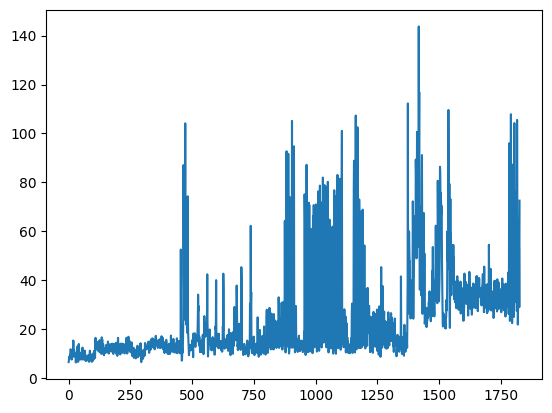

(1826,)


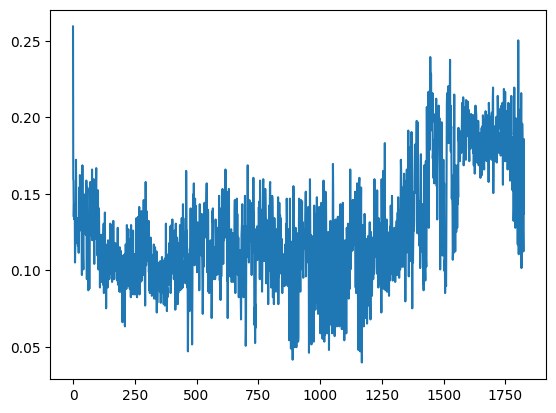

(1826,)


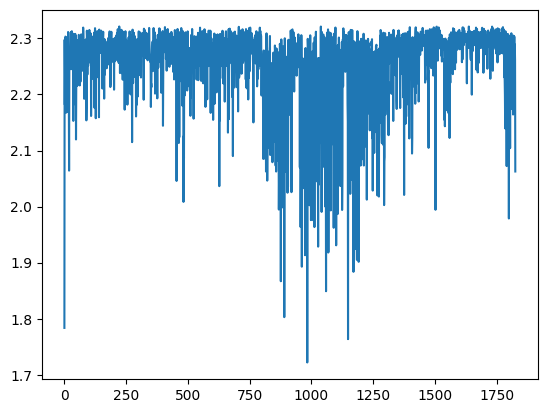

(1826,)


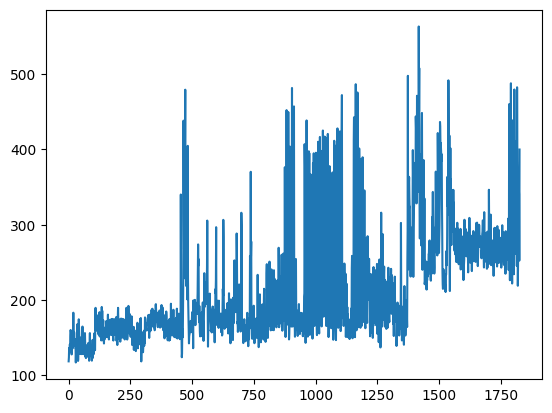

(1826,)


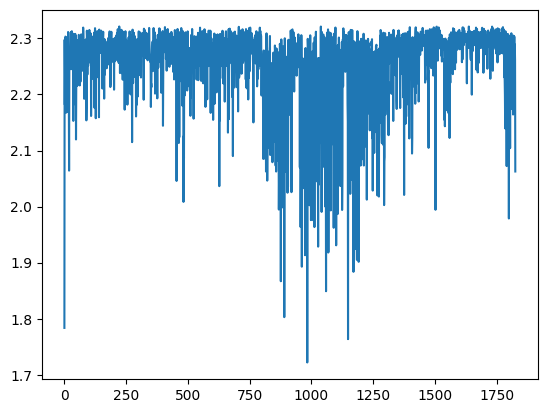

(1824,)


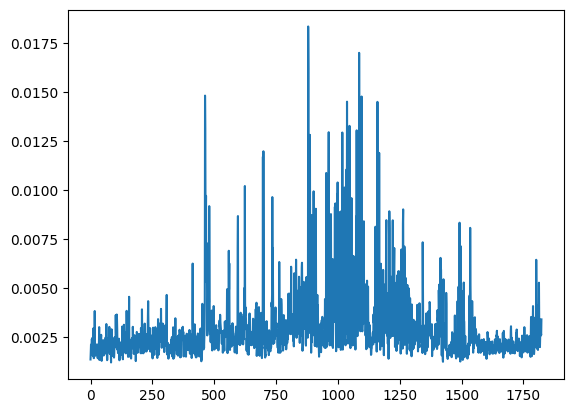

(1828, 20)


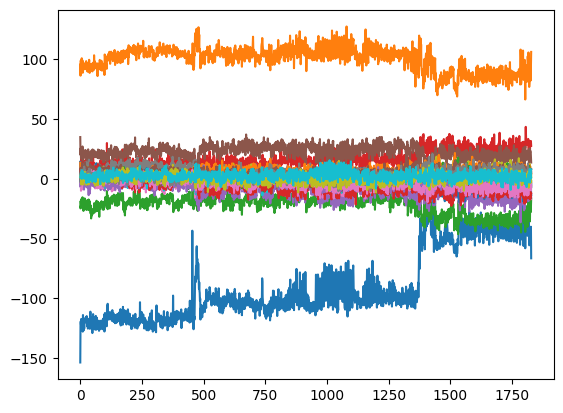

(110, 3656) (111,) (552, 3656)


In [44]:
audio_file = "../KeyRing1/label/labeled/KeyD.mp3"
frame_length_ms = 50  # e.g., 20 millisecond
K = 5

energies = frame_energy(audio_file, frame_length_ms)
print(energies.shape)
plt.plot(energies)
plt.show()
zcrs = compute_zcr(audio_file, frame_length_ms)
print(zcrs.shape)
plt.plot(zcrs)
plt.show()
energy_entropy = compute_energy_entropy(audio_file, frame_length_ms, K)
print(energy_entropy.shape)
plt.plot(energy_entropy)
plt.show()
fft_data = compute_fft_magnitudes(audio_file, frame_length_ms)
print(fft_data.shape)
plt.plot(fft_data)
plt.show()
spectral_entropy = compute_spectral_entropy(audio_file, frame_length_ms, K)
print(energy_entropy.shape)
plt.plot(energy_entropy)
plt.show()

#iska size chud rha hai. plox fix kro.
flux_data = compute_spectral_flux(audio_file, frame_length_ms)
print(flux_data.shape)
plt.plot(flux_data)
plt.show()

#iska size bhi bohot chud rha hai. plox fix kro.
mfcc_frames = extract_mfcc_from_frames(audio_file, frame_length_ms)
print(mfcc_frames.shape)
plt.plot(mfcc_frames)
plt.show()

#I'm 69.420% sure that this is wrong
energy_bins, bin_edges, stft = compute_energy_bins(audio_file, frame_length_ms)
print(energy_bins.shape, bin_edges.shape, stft.shape)